# Discovery Metrics with Uncertainties

The next step is to incorporate uncertainties into our light curves (eventually this will actually involve some detailed calculations, but for now we will use a relatively simplified procedure). The way to determine the uncertainties on a single photometric observation is laid out in Section 3.5 of the LSST definition paper (Ivezic et al. 2008) - note this paper is super long and I recommend only looking at Sec 3.5 for now.

$1$. Eqn 3.1 says the uncertainty is defined as sigma_1^2 = sigma_sys^2 + sigma_rand^2, where the two terms correspond to systematic and random errors. As a side note - for bright sources systematic uncertainties are all that matters, while for faint sources random errors are all that matters. We will adopt sigma_sys = 0.005 mag, as suggested by Ivezic. 

$2$. Calculating sigma_rand is more complicated (Egn 3.2) as we need to know a gamma term (given in Table 3.2) and to calculate m_5, which in turn depends on many other factors. Eventually we will incorporate all of those factors for every observation, but for now we will simply assume that all observations are taken at the meridian (i.e. X = 1). We also assume t_vis = 30 sec. These two assumptions mean the last two terms in Eqn 3.3. are equal to zero, and therefore m_5 will be different in each filter but it can be easily calculated.

$3$. Now we need to simulate an observation, which involves the following steps: 

    i. From the model get the true value of the mag (m_true) for the source and use this to calculate sigma_rand
        
    ii. Use the numpy random module to to select a random number from a gaussian (np.random.normal) with mean m_true and standard deviation sigma_rand - this value is the observed brightness m_obs
    
    iii. Now that we have the magnitude that LSST observes, we need to recalculate sigma_rand (this time using m_obs instead of m_true)
    
    iv. Combine sigma_rand and sigma_sys in order to get sigma_1. This is the uncertainty on your observation.
    

$4$. This procedure then needs to be repeated for all observations. 

$5$. Finally, for our "detection metrics" (i.e. u - z > 0.5 mag) we need to set a significance threshold. What I mean here is that we need to detect a red color, but we need to detect it at 1 sigma, or 2 sigma, or 3 sigma or whatever. I think for now we should be really stringent and require a 3 sigma detection. To calculate the error on u -z, sigma_uz, you can use the following calculation: 

sigma_uz = sqrt( sigma_u^2 + sigma_z^2 )

In cases where u - z / sigma_uz < 3 we do not detect the kilonova, even if u - z > 0.5 mag. 

I would like for you to incorporate these uncertainties into the models and then remake the efficiency plots that you have previously made. 

In [1]:
#Necessary files needed for plotting the curves and manipulating the data.

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astropy as astro
from astropy.table import Table,Column
from astropy.io import ascii
from astropy.cosmology import WMAP9 as cosmo
from scipy.interpolate import interp1d
plt.rcParams["figure.figsize"] = (10,8)
%matplotlib inline
#We will need to grab the data from where it is saved on the computer.

#NS-NS
APR1215 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4-1215.txt')
APR1314 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4-1314.txt')
H41215 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4-1215.txt')
H41314 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4-1314.txt')
Sly135 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/Sly-135.txt')

#NS-BH
APR4Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/APR4Q3a75.txt')
H4Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/H4Q3a75.txt')
MS1Q3a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/MS1Q3a75.txt')
MS1Q7a75 = ascii.read('/Users/kristophermortensen/Desktop/Kilonova Light Curve Data/MS1Q7a75.txt')

In [2]:
# Constants:
title = 22
subtitle = 20
axis = 16
ticksize = 12
legend = 12

redshift = 0.015


#Convert Absolute Magnitude to Apparent Magnitude

#app_mag: Merger Number -> Merger
#Converts the merger data from absolute magnitude to apparent magnitude.
def app_mag(merger, redshift):
    merger['u']=app_mag_band(merger['u'],redshift)
    merger['g']=app_mag_band(merger['g'],redshift)
    merger['r']=app_mag_band(merger['r'],redshift)
    merger['i']=app_mag_band(merger['i'],redshift)
    merger['z']=app_mag_band(merger['z'],redshift)
    return merger

#app_mag_band: ListofNumbers Number -> ListofNumbers
#converts all the absolute magnitudes into apparent magnitudes.
def app_mag_band(data, redshift):
    return 5*np.log10(lumo_dist(redshift)/10)+data

#lumo_dist: Number -> Number
#converts redshift to luminosity distance
def lumo_dist(redshift):
    return cosmo.luminosity_distance(redshift).to(astro.units.pc).value


#NS-NS Conversions:
APR1215_app=app_mag(APR1215, redshift)
APR1314_app=app_mag(APR1314, redshift)
H41215_app=app_mag(H41215, redshift)
H41314_app=app_mag(H41314, redshift)
Sly135_app=app_mag(Sly135, redshift)

#NS-BH Conversions:
APR4Q3a75_app=app_mag(APR4Q3a75, redshift)
H4Q3a75_app=app_mag(H4Q3a75, redshift)
MS1Q3a75_app=app_mag(MS1Q3a75, redshift)
MS1Q7a75_app=app_mag(MS1Q7a75, redshift)

## Light Curves (NS-NS & NS-BH)

In [78]:
#full_plot: Merger String String -> Image
#Takes the data from the Merger and plots the magnitudes and interpolations of each associated
# photometric band as a function of time measured in days.
def full_plot(merger,name):
    fig=plt.figure(figsize=(12,11))
    ax=fig.add_subplot(111)
    abs_plotter1(merger)
    abs_plot_interp(merger)
    LSST_plot(merger)
    ax.axis([0,35,rounded_up(correct_max(merger))+5,(rounded_down(correct_min(merger))-5)])
    ax.tick_params(labelsize=ticksize)
    plt.title("Light Curve of " + name, fontsize=title)
    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.xlabel("Time (Days)", fontsize=axis)
    plt.ylabel('Magnitude', fontsize=axis)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':legend})
    return

#abs_plotter1 Merger -> Image
#Plots the data from the ascii.reads of the merger.
def abs_plotter1(merger):
    plot_band(merger, 'u', '.', 'b')
    plot_band(merger, 'g', '.', 'g')
    plot_band(merger, 'r', '.', 'y')
    plot_band(merger, 'i', '.', 'orange')
    plot_band(merger, 'z', '.', 'r')
    return

#plot_band: Merger String String String -> Image
#Plots the magnitudes of a photometric band in the merger.
def plot_band(merger, band, style, color):
    plt.plot(merger['day'], merger[band], style, color=color, label=band)
    return

#abs_plotter1 Merger -> Image
#Plots the interpolations calculated from data from the ascii.reads of the merger.
def abs_plot_interp(merger):
    plot_interp(merger, 'u', '--', 'b', 0)
    plot_interp(merger, 'g', '--', 'g', 1)
    plot_interp(merger, 'r', '--', 'y', 2)
    plot_interp(merger, 'i', '--', 'orange', 3)
    plot_interp(merger, 'z', '--', 'r', 4)
    return

#plot_interp: Merger String String String Number -> Image
#Plots the interpolation of a photometric band in the merger.
def plot_interp(merger, name, style, color, number):
    plt.plot(day_new(merger, name), interpolate(merger)[number](day_new(merger, name)),
             style, color=color, label=name+' interp.')
    return

#interpolate: Merger-> List of Interpolations
#Provides the necessary interpolation functions of the mergers in each associated photometric bands. 
def interpolate(merger):
    LSST_u=23.9
    LSST_g=25.0
    LSST_r=24.7
    LSST_i=24.0
    LSST_z=23.3
    approx='cubic'
    u=interp1d(merger['day'][np.isfinite(merger['u'])], merger['u'][np.isfinite(merger['u'])],
               kind=approx, bounds_error=False, fill_value=LSST_u)
    g=interp1d(merger['day'][np.isfinite(merger['g'])], merger['g'][np.isfinite(merger['g'])],
               kind=approx, bounds_error=False, fill_value=LSST_g)
    r=interp1d(merger['day'][np.isfinite(merger['r'])], merger['r'][np.isfinite(merger['r'])],
               kind=approx, bounds_error=False, fill_value=LSST_r)
    i=interp1d(merger['day'][np.isfinite(merger['i'])], merger['i'][np.isfinite(merger['i'])],
               kind=approx, bounds_error=False, fill_value=LSST_i)
    z=interp1d(merger['day'][np.isfinite(merger['z'])], merger['z'][np.isfinite(merger['z'])],
               kind=approx, bounds_error=False, fill_value=LSST_z)
    return [u, g, r, i, z]

#day_new Merger String -> List of Numbers
#Produces a new set of points between the range of the 'day' column in the merger data. 
# This is useful for plotting the interpolations.

def day_new(merger, band):
    set_length=100
    day_new = np.linspace(min(merger['day'][np.isfinite(merger[band])]),
                          max(merger['day'][np.isfinite(merger[band])]),set_length)
    return day_new

#LSST_plot: Merger -> Image
#Plots graphs of the LSST's 5-sigma depths in all five bands.
def LSST_plot(merger):
    LSST_u=(merger['day']/merger['day'])-1+23.9
    LSST_g=(merger['day']/merger['day'])-1+25.0
    LSST_r=(merger['day']/merger['day'])-1+24.7
    LSST_i=(merger['day']/merger['day'])-1+24.0
    LSST_z=(merger['day']/merger['day'])-1+23.3
    plt.plot(merger['day'], LSST_u, 'b', label='LSST \n u-band')
    plt.plot(merger['day'], LSST_g, 'g', label='LSST \n g-band')
    plt.plot(merger['day'], LSST_r, 'y', label='LSST \n r-band')
    plt.plot(merger['day'], LSST_i, 'orange', label='LSST \n i-band')
    plt.plot(merger['day'], LSST_z, 'r', label='LSST \n z-band')
    return

#correct_max: Merger -> Number
#Outputs the largest magnitude in the entire merger data.
def correct_max(merger):
    max_list = [max(merger['u'][np.isfinite(merger['u'])]), 
                max(merger['g'][np.isfinite(merger['g'])]), 
                max(merger['r'][np.isfinite(merger['r'])]),
                max(merger['i'][np.isfinite(merger['i'])]),
                max(merger['z'][np.isfinite(merger['z'])])]
    return max(max_list)

#correct_min: Merger -> Number
#Outputs the smallest magnitude in the entire merger data.
def correct_min(merger, band):
    min_list = [min(merger['u'][np.isfinite(merger['u'])]), 
                min(merger['g'][np.isfinite(merger['g'])]), 
                min(merger['r'][np.isfinite(merger['r'])]),
                min(merger['i'][np.isfinite(merger['i'])]),
                min(merger['z'][np.isfinite(merger['z'])])]
    return min_list

#round_up: number base -> number
#Rounds the number up to the nearest multiple of the base number.
def rounded_up(x, base=5):
    return int(base * (round(float(x)/base)+1))

#round_down: number base -> number
#Rounds the number down to the nearest multiple of the base number.
def rounded_down(x, base=5):
    return int(base * (round(float(x)/base)))

In [4]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

majorLocator = MultipleLocator(5)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(1)

bands=['u','g','r', 'i', 'z']

#rand_plot: Merger String String String -> Image
#Plots a randomly chosen band from the merger.
def band_plot(merger, name):
    LSST_u=(merger['day']/merger['day'])-1+23.9
    LSST_g=(merger['day']/merger['day'])-1+25.0
    LSST_r=(merger['day']/merger['day'])-1+24.7
    LSST_i=(merger['day']/merger['day'])-1+24.0
    LSST_z=(merger['day']/merger['day'])-1+23.3
    fig=plt.figure(figsize=(10,25))
    for band in bands:
        if band == 'u':
            band_graph(merger, 'u', 'b', 511, 0, LSST_u)
        elif band == 'g':
            band_graph(merger, 'g', 'g', 512, 1, LSST_g)
        elif band == 'r':
            band_graph(merger, 'r', 'y', 513, 2, LSST_r)
        elif band == 'i':
            band_graph(merger, 'i', 'orange', 514, 3, LSST_i)
        elif band == 'z':
            band_graph(merger, 'z', 'r', 515, 4, LSST_z)
    plt.suptitle("Light Curve Bands of " + name, fontsize=title, y=1.01)
    plt.tight_layout()
    return

def band_graph(merger, band, color, sub_num, num, LSST_band):
    ax = plt.subplot(sub_num)
    plot_band(merger, band, '.', color)
    plot_interp(merger, band, '--', color, num)
    plt.plot(merger['day'], LSST_band, color, label='LSST (' + band + ')')
    plt.axis([0,35,rounded_up(correct_max(merger))+5,(rounded_down(correct_min(merger))-5)])
    ax.xaxis.set_major_locator(majorLocator)
    ax.xaxis.set_major_formatter(majorFormatter)
    ax.xaxis.set_minor_locator(minorLocator)
    plt.xlabel("Time (Days)", fontsize=axis)
    plt.ylabel('Magnitude', fontsize=axis)
    ax.tick_params(labelsize=ticksize)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':legend})
    return

### NS-NS Mergers (Apparent Magnitude)

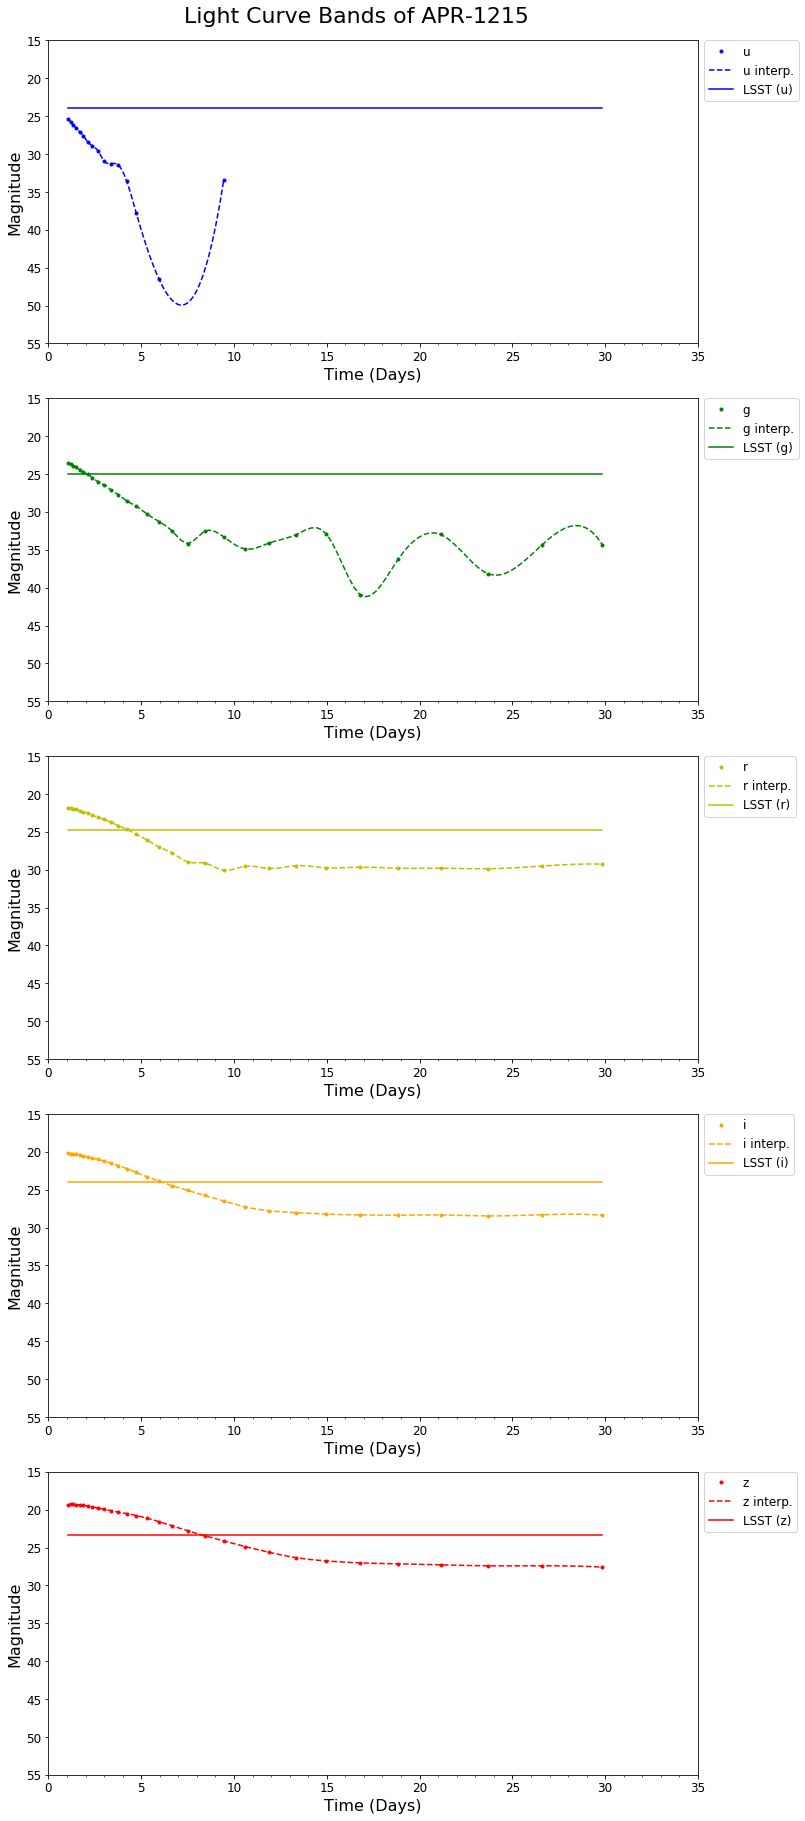

In [5]:
#The following are plots of only the data and the interpolations retrived from the data files in the ascii.reads, 
# converted into apparent magnitude.
full_plot(APR1215_app, "APR-1215")
plt.close()
band_plot(APR1215_app, "APR-1215")


In [6]:
full_plot(APR1314_app, "APR4-1314")
plt.close()
band_plot(APR1314_app, "APR4-1314")
plt.close()

In [7]:
full_plot(H41215_app, "H4-1215")
plt.close()
band_plot(H41215_app, "H4-1215")
plt.close()

In [8]:
full_plot(H41314_app, "H4-1314")
plt.close()
band_plot(H41314_app, "H4-1314")
plt.close()

In [9]:
full_plot(Sly135_app, "Sly-135")
plt.close()
band_plot(Sly135_app, "Sly-135")
plt.close()

### NS-BH Mergers (Apparent Magnitude)

In [10]:
#The following are plots of only the data and the interpolations retrived from the data files in the ascii.reads, 
# converted into apparent magnitude.
full_plot(APR4Q3a75_app, 'APR4Q3a75')
plt.close()
band_plot(APR4Q3a75_app, 'APR4Q3a75')
plt.close()

In [11]:
full_plot(H4Q3a75_app, 'H4Q3a75')
plt.close()
band_plot(H4Q3a75_app, 'H4Q3a75')
plt.close()

In [12]:
full_plot(MS1Q3a75_app, 'MS1Q3a75')
plt.close()
band_plot(MS1Q3a75_app, 'MS1Q3a75')
plt.close()

In [13]:
full_plot(MS1Q7a75_app, 'MS1Q7a75')
plt.close()
band_plot(MS1Q7a75_app, 'MS1Q7a75')
plt.close()

## Uncertainty Calculations

In [14]:
# Table of parameters necessary for uncertainty calculations
parameters = Table([['m_sky', 'theta', 'gamma', 'k_m', 'C_m', 'm_5', 'del_C', 'del_C2', 'del_m_5'],
                    [22.9, 0.77, 0.037, 0.451, 22.92, 23.68, 0.67, 0.24, 0.21],
                    [22.3, 0.73, 0.038, 0.163, 24.29, 24.89, 0.21, 0.09, 0.15],
                    [21.2, 0.70, 0.039, 0.087, 24.33, 24.43, 0.11, 0.05, 0.14],
                    [20.5, 0.67, 0.039, 0.065, 24.20, 24.00, 0.08, 0.04, 0.13], 
                    [19.6, 0.65, 0.040, 0.043, 24.07, 24.45, 0.05, 0.03, 0.13],
                    [18.6, 0.63, 0.040, 0.138, 23.69, 22.60, 0.04, 0.02, 0.15,]],
                  names = ('parameters','u', 'g', 'r', 'i', 'z', 'y'))

In [15]:
parameters

parameters,u,g,r,i,z,y
str7,float64,float64,float64,float64,float64,float64
m_sky,22.9,22.3,21.2,20.5,19.6,18.6
theta,0.77,0.73,0.7,0.67,0.65,0.63
gamma,0.037,0.038,0.039,0.039,0.04,0.04
k_m,0.451,0.163,0.087,0.065,0.043,0.138
C_m,22.92,24.29,24.33,24.2,24.07,23.69
m_5,23.68,24.89,24.43,24.0,24.45,22.6
del_C,0.67,0.21,0.11,0.08,0.05,0.04
del_C2,0.24,0.09,0.05,0.04,0.03,0.02
del_m_5,0.21,0.15,0.14,0.13,0.13,0.15


In [16]:
#Constants:
sigma_sys = 0.005
X = 1
t_vis = 30

In [168]:
def sigmas(mags, band):
    sigmas = []
    for mag in mags:
        sigmas.append(sigma_1(mag, band))
    return sigmas

def sigma_1(mag, band):
    sigma1 = np.float(np.sqrt(sigma_sys**2 + sigma_rand(mag, band, parameters)**2))
    return sigma1


def sigma_rand(mag, band, parameters):
    gamma = parameters[band][np.where(parameters['parameters']=='gamma')]
    return np.float((0.04-gamma)*x(mag, band, parameters) + gamma*x(mag, band, parameters)**2)

def x(mag, band, parameters):
    return np.float(10**(0.4*(mag-m_5(band, parameters, X, t_vis))))

def m_5(band, parameters=parameters, X=1, t_vis=30):
    C_m = parameters[band][np.where(parameters['parameters']=='C_m')]
    m_sky = parameters[band][np.where(parameters['parameters']=='m_sky')]
    theta = parameters[band][np.where(parameters['parameters']=='theta')]
    k_m = parameters[band][np.where(parameters['parameters']=='k_m')]
    m_5 = C_m+0.50*(m_sky-21)+2.5*np.log10(0.7/theta)+1.25*np.log10(t_vis/30)-k_m*(X-1)
    return np.float(m_5)

In [18]:
def sigma_plot(merger, name):
    fig = plt.figure(figsize=((10,25)))
    plot_sigmas(merger)
    #ax.axis([0,35,rounded_up(correct_max(merger))+5,(rounded_down(correct_min(merger))-5)])
    plt.suptitle("$\sigma$ Error of " + name, fontsize=title+5, y=1.01)
    plt.tight_layout()
    return


def plot_sigmas(merger):
    plot_sigma(merger, 'u', 0, 'blue', 511)
    plot_sigma(merger, 'g', 1, 'green', 512)
    plot_sigma(merger, 'r', 2, 'y', 513)
    plot_sigma(merger, 'i', 3, 'orange', 514)
    plot_sigma(merger, 'z', 4, 'red', 515)
    return

def plot_sigma(merger, band, number, color, placement):
    plt.subplot(placement)
    plt.plot(interpolate(merger)[number](day_new(merger, band)),
             sigmas(interpolate(merger)[number](day_new(merger, band)), band),
             color=color, label='$\sigma_{'+band+'}$')
    plt.tick_params(labelsize=ticksize)
    plt.xlabel("Magnitude", fontsize=axis+5)
    plt.xlim(15,30)
    plt.ylim(0.001, 10)
    plt.yscale('log')
    plt.ylabel('$\sigma$', fontsize=axis+5)
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':legend+5})

### NS-NS $\mathbf{\sigma}$ Plots

In [19]:
sigma_plot(APR1215_app, 'APR4-1215')
plt.close()

In [20]:
sigma_plot(APR1314_app, 'APR4-1314')
plt.close()

In [21]:
sigma_plot(H41215_app, "H4-1215")
plt.close()

In [22]:
sigma_plot(H41314_app, "H4-1314")
plt.close()

In [23]:
sigma_plot(Sly135_app, "Sly-135")
plt.close()

### NS-BH $\mathbf{\sigma}$ Plots

In [24]:
sigma_plot(APR4Q3a75_app, 'APR4Q3a75')
plt.close()

In [25]:
sigma_plot(H4Q3a75_app, 'H4Q3a75')
plt.close()

In [26]:
sigma_plot(MS1Q3a75_app, 'MS1Q3a75')
plt.close()

In [27]:
sigma_plot(MS1Q7a75_app, 'MS1Q7a75')
plt.close()

## Random Observation Light Curves

In [28]:
def rand_mags(merger):
    u = []
    g = []
    r = []
    i = []
    z = []
    days = np.array(merger['day'])
    for day in days:
        u.append(rand_mag(merger, 'u', day, 0))        
        g.append(rand_mag(merger, 'g', day, 1))        
        r.append(rand_mag(merger, 'r', day, 2))       
        i.append(rand_mag(merger, 'i', day, 3))       
        z.append(rand_mag(merger, 'z', day, 4))
    return Table([days, u, g, r, i, z], names=('day', 'u', 'g', 'r', 'i', 'z'))

def rand_mag(merger, band, day, number):
    if interpolate(merger)[number](day) > m_5(band, parameters, X, t_vis):
        m_true = m_5(band, parameters, X, t_vis)
        
    else:
        m_true = interpolate(merger)[number](day)
    
    stdev = sigma_1(m_true, band)        
    
    if m_true == m_5(band, parameters, X, t_vis):
        m_obs = m_5(band, parameters, X, t_vis)
    else:
        m_obs = np.random.normal(m_true, stdev)
    return m_obs

def obs_sigmas(merger):
    u = sigmas(merger['u'], 'u')
    g = sigmas(merger['g'], 'g')
    r = sigmas(merger['r'], 'r')
    i = sigmas(merger['i'], 'i')
    z = sigmas(merger['z'], 'z')
    return Table([u, g, r, i, z], names=('u-sig', 'g-sig', 'r-sig', 'i-sig', 'z-sig'))

In [29]:
#NS-NS Magnitudes

In [30]:
APR1215_rand = rand_mags(APR1215_app)
APR1314_rand = rand_mags(APR1314_app)
H41215_rand = rand_mags(H41215_app)
H41314_rand = rand_mags(H41314_app)
Sly135_rand = rand_mags(Sly135_app)

In [31]:
#NS-BH Magnitudes

In [32]:
APR4Q3a75_rand = rand_mags(APR4Q3a75_app)
H4Q3a75_rand = rand_mags(H4Q3a75_app)
MS1Q3a75_rand = rand_mags(MS1Q3a75_app)
MS1Q7a75_rand = rand_mags(MS1Q7a75_app)

In [154]:
majorLocator = MultipleLocator(1)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(0.25)


def uplim(merger, band):
    limits=[]
    regular=[]
    lim_days=[]
    reg_days=[]
    for mag in merger[band]:
        if mag == m_5(band, parameters, X, t_vis):
            limits.append(mag)
        else:
            regular.append(mag)
            reg_days.append(np.float(merger[np.where(merger[band] == mag)]['day']))
    
    y = np.array(merger[np.where(merger[band] == m_5(band, parameters, X, t_vis))]['day'])
    
    for x in y:
        lim_days.append(x)
    
    return {'regular': regular, 'limits': limits, 'reg days': reg_days, 'lim days': lim_days}

#rand_plot: Merger String String String -> Image
#Plots a randomly chosen band from the merger.
def band_plot_rand(merger, merger1, name):
    LSST_u=(merger['day']/merger['day'])-1+m_5('u', parameters, X, t_vis)
    LSST_g=(merger['day']/merger['day'])-1+m_5('g', parameters, X, t_vis)
    LSST_r=(merger['day']/merger['day'])-1+m_5('r', parameters, X, t_vis)
    LSST_i=(merger['day']/merger['day'])-1+m_5('i', parameters, X, t_vis)
    LSST_z=(merger['day']/merger['day'])-1+m_5('z', parameters, X, t_vis)
    fig=plt.figure(figsize=(12,30))
    for band in bands:
        if band == 'u':
            band_graph_rand(merger, 'u', 'b', 511, 0, LSST_u, merger1)
        elif band == 'g':
            band_graph_rand(merger, 'g', 'g', 512, 1, LSST_g, merger1)
        elif band == 'r':
            band_graph_rand(merger, 'r', 'y', 513, 2, LSST_r, merger1)
        elif band == 'i':
            band_graph_rand(merger, 'i', 'orange', 514, 3, LSST_i, merger1)
        elif band == 'z':
            band_graph_rand(merger, 'z', 'r', 515, 4, LSST_z, merger1)
    plt.suptitle("Light Curve Bands of " + name, fontsize=title, y=1.01)
    plt.tight_layout()
    return

def band_graph_rand(merger, band, color, sub_num, num, LSST_band, merger1):
    ax = plt.subplot(sub_num)
    l1 = plot_band_rand(merger, band, '.', color)
    l2 = plot_interp(merger1, band, '-', color, num)
    l3 = plt.plot(merger['day'], LSST_band, color, label='LSST (' + band + ')')
    l4 = plot_band_limits(merger, band, 'none', color)
    plt.xlim(0,uplim(merger, band)['lim days'][0]+0.1)
    plt.ylim(m_5(band, parameters)+0.1, (correct_min_band(merger, band)-0.1))
    plt.xlabel("Time (Days)", fontsize=axis)
    plt.ylabel('Magnitude', fontsize=axis)
    ax.tick_params(labelsize=ticksize)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':legend})
    return

#plot_band: Merger String String String -> Image
#Plots the magnitudes of a photometric band in the merger.
def plot_band_rand(merger, band, style, color):
    plt.errorbar(uplim(merger, band)['reg days'], uplim(merger, band)['regular'],
                 yerr=sigmas(uplim(merger, band)['regular'], band), fmt=style,
                 color=color, markeredgecolor='black', markersize=7, capsize = 5, elinewidth = 2,
                 label=produce_label(uplim(merger, band)['regular'], band))
    return

def plot_band_limits(merger, band, style, color):
    plt.errorbar(uplim(merger, band)['lim days'], uplim(merger, band)['limits'],
                 yerr=sigma_1(m_5(band, parameters), band), fmt=style, uplims=True,
                 color=color, markeredgecolor='black', capsize = 5)
    return

def produce_label(lim_list, band):
    if len(lim_list) == 0:
        label = None
    else:
        label = band
    return label

def correct_min_band(merger, band):
    minimum = min(merger[band][np.isfinite(merger[band])])
    return minimum

### NS-NS Random Light Curves

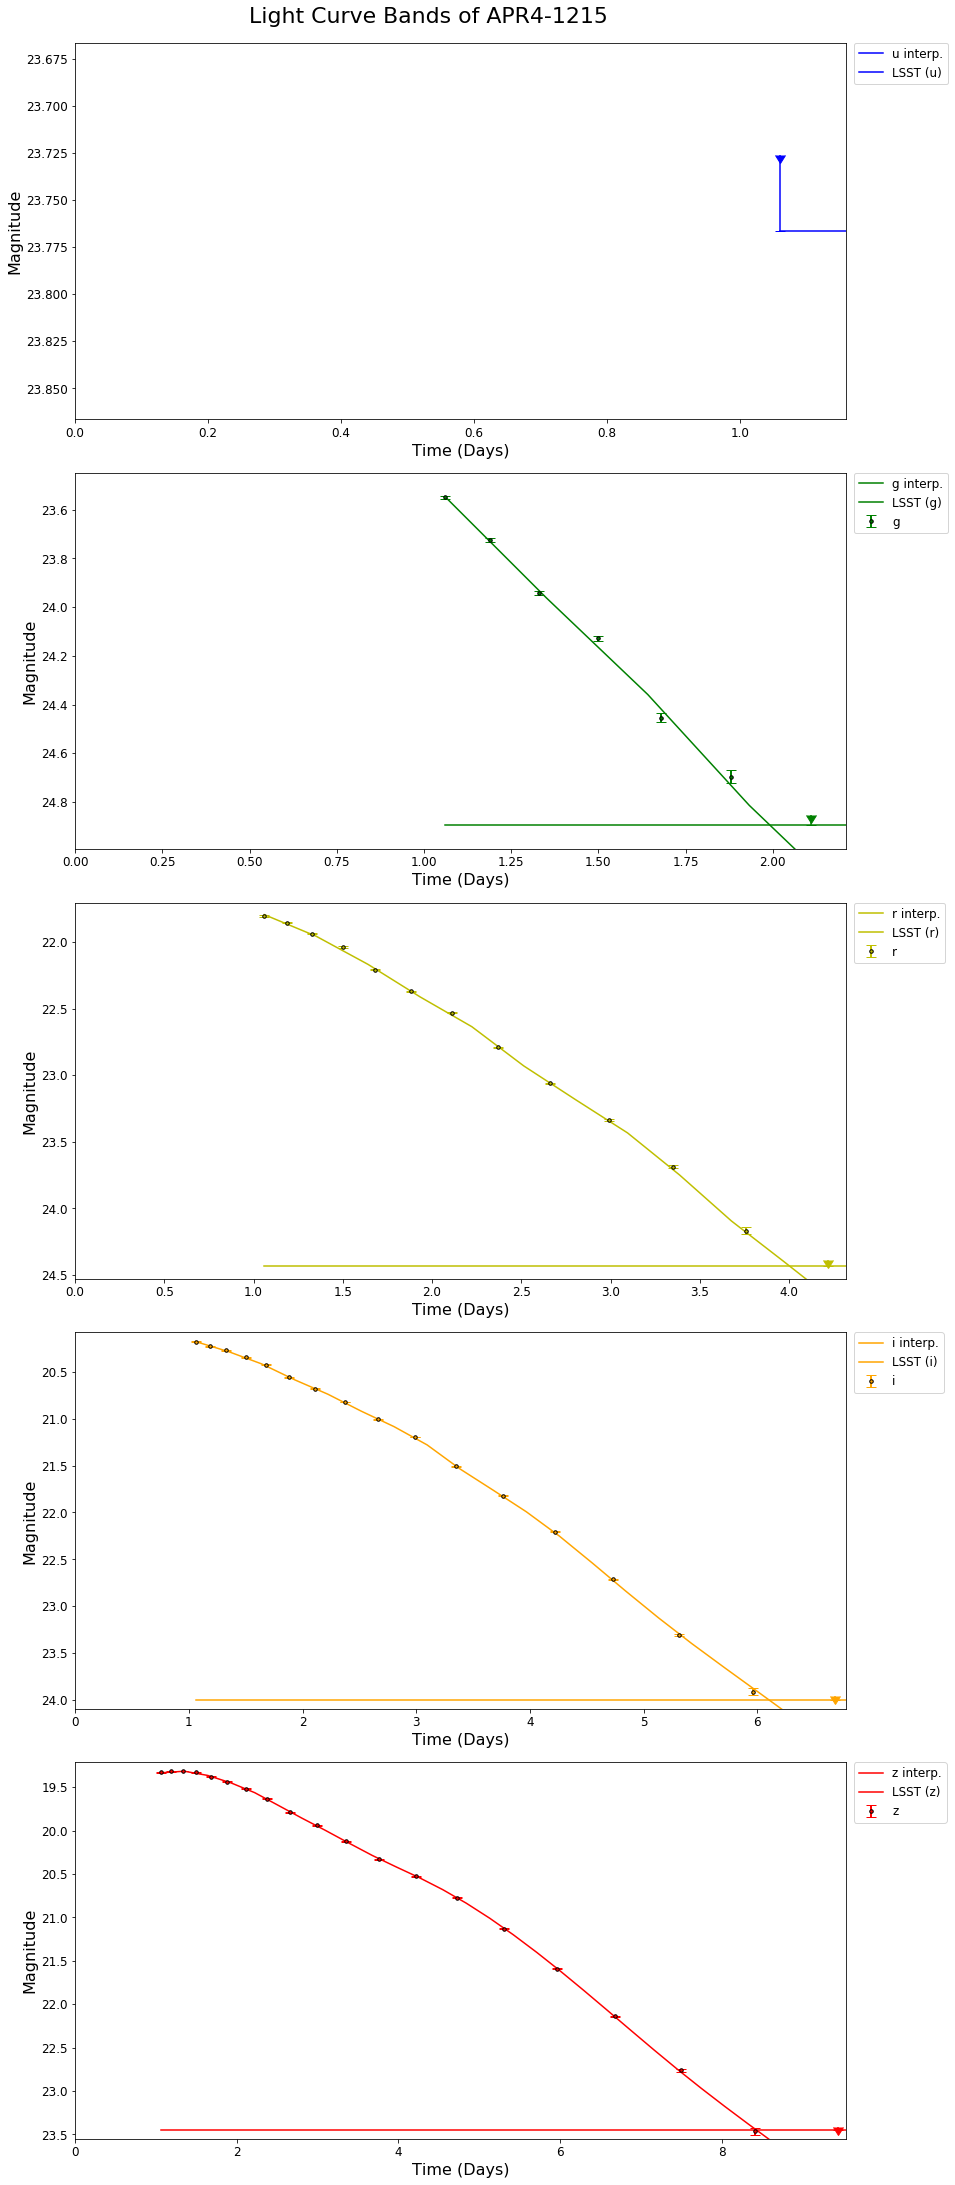

In [155]:
band_plot_rand(APR1215_rand, APR1215_app, 'APR4-1215')

In [156]:
band_plot_rand(APR1314_rand, APR1314_app, 'APR4-1314')
plt.close()

In [157]:
band_plot_rand(H41215_rand, H41215_app, 'H4-1215')
plt.close()

In [158]:
band_plot_rand(H41314_rand, H41314_app, 'H4-1314')
plt.close()

In [165]:
band_plot_rand(Sly135_rand, Sly135_app, 'Sly-135')
plt.close()

### NS-BH Random Light Curves

In [160]:
band_plot_rand(APR4Q3a75_rand, APR4Q3a75_app, 'APR4Q3a75')
plt.close()

In [161]:
band_plot_rand(H4Q3a75_rand, H4Q3a75_app, 'H4Q3a75')
plt.close()

In [162]:
band_plot_rand(MS1Q3a75_rand, MS1Q3a75_app, 'MS1Q3a75')
plt.close()

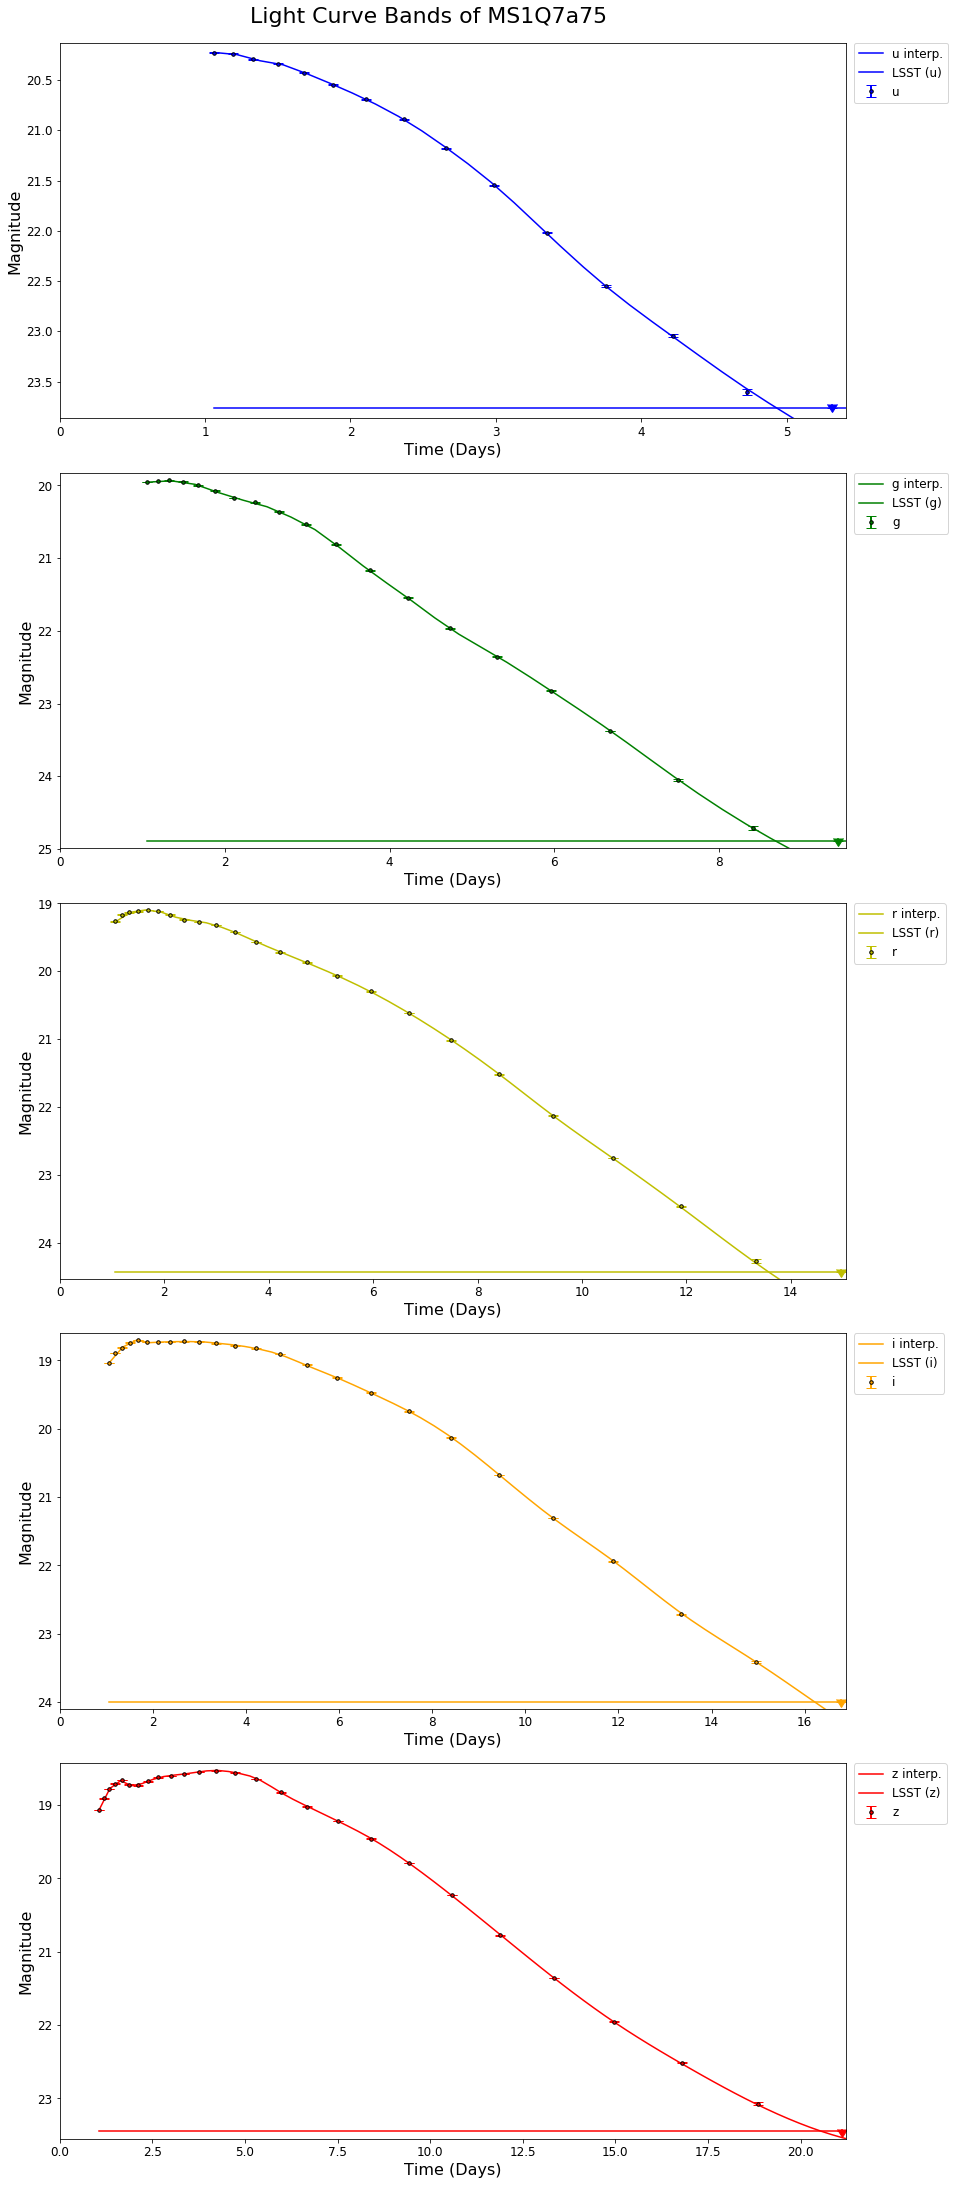

In [226]:
band_plot_rand(MS1Q7a75_rand, MS1Q7a75_app, 'MS1Q7a75')


## Discovery Metric Analysis with Random Light Curves

In [259]:
import random 

trial_num = 2000

def Analyze(merger):
    time = weather_output(merger)
    colors = measure_color(merger, time)
    discoveries = []
    distance = []
    for i in range(len(colors['Color (Epoch 1)'])):
        distance.append(rand_dist(merger))
        if colors['Color (Epoch 1)'][i] > 0.5 and \
        np.divide(colors['Color (Epoch 1)'][i], colors['Sigmas (Epoch 1)'][i]) > 3 and \
        colors['Color (Epoch 2)'][i] > 0.5 and \
        np.divide(colors['Color (Epoch 2)'][i], colors['Sigmas (Epoch 2)'][i]) > 3 and \
        colors['$\Delta m_{3}$ (z-band)'][i] > 1.0:
            discoveries.append(1)
        else:
            discoveries.append(0)
    return Table([colors['Band'], distance, discoveries], names=('Band', 'Distance (Mpc)', 'Discovery'))


def measure_color(merger, time0):
    bands = ['u', 'g', 'r', 'i']
    time = time0
    color_list1 = []
    color_sigs1 = []
    color_list2 = []
    color_sigs2 = []
    band_list = []
    delta_z = []
    for t1,t2 in zip(time['Epoch 1'], time['Epoch 2']):
        band = random.choice(bands)
        band_list.append(band+'-z')
        
        color1 = np.subtract(get_mag(merger, band, t1),get_mag(merger, 'z', t1))
        color_list1.append(color1)
        sigs1 = np.sqrt(np.add(np.square(sigma_1(get_mag(merger, band, t1), band)), 
                       np.square(sigma_1(get_mag(merger, 'z', t1), 'z')))) 
        color_sigs1.append(sigs1)
        
        color2 = np.subtract(get_mag(merger, band, t2),get_mag(merger, 'z', t2))
        color_list2.append(color2)
        sigs2 = np.sqrt(np.add(np.square(sigma_1(get_mag(merger, band, t2), band)), 
                       np.square(sigma_1(get_mag(merger, 'z', t2), 'z'))))
        color_sigs2.append(sigs2)
        
        z = get_mag(merger, 'z', t2)-get_mag(merger, 'z', t1)
        delta_z.append(z)
    return Table([band_list, color_list1, color_list2, color_sigs1, color_sigs2, delta_z],
                 names=('Band', 'Color (Epoch 1)', 'Color (Epoch 2)',
                        'Sigmas (Epoch 1)', 'Sigmas (Epoch 2)', '$\Delta m_{3}$ (z-band)'))
    

def weather_output(merger):
    time = np.empty((trial_num,2))
    for i in range(len(time[:,1])):
        t = random.random()+1.06
        t1 = weather_simulator(t)
        t2 = weather_simulator(t1+3)
        time[i,0] = t1
        time[i,1] = t2
    return Table([time[:,0], time[:,1]], names=('Epoch 1', 'Epoch 2'))
    


def weather_simulator(time):
    weather = random.random()
    if weather < 0.8:
        time = time
    else:
        time = weather_simulator(time+1)
    return time


#detect: Merger String Number -> Boolean
#Determines if LSST can detect the light curve of a specific band at a specific time.
def detect(merger, band, time):
    LSST_u=m_5('u')
    LSST_g=m_5('g')
    LSST_r=m_5('r')
    LSST_i=m_5('i')
    LSST_z=m_5('z')
    if band == 'u':
        mag_u = rand_mag(merger, band, time, 0)+0.5
        return in_view(mag_u, LSST_u)
    elif band == 'g':
        mag_g = rand_mag(merger, band, time, 1)+0.5
        return in_view(mag_g, LSST_g)
    elif band == 'r':
        mag_r = rand_mag(merger, band, time, 2)+0.5
        return in_view(mag_r, LSST_r)
    elif band == 'i':
        mag_i = rand_mag(merger, band, time, 3)+0.5
        return in_view(mag_i, LSST_i)
    elif band == 'z':
        mag_z = rand_mag(merger, band, time, 4)+0.5
        return in_view(mag_z, LSST_z)
    return

#in_view: Number Number -> Boolean
#Checks if LSST can detect the light curve based on magnitude.
def in_view(mag, LSST):
    if mag < LSST:
        return True
    else:
        return False
    return


def get_mag(merger, band, time):
    LSST_u=m_5('u')
    LSST_g=m_5('g')
    LSST_r=m_5('r')
    LSST_i=m_5('i')
    LSST_z=m_5('z')
    mag = 0
    if detect(merger, band, time)==True:
        if band == 'u':
            mag = rand_mag(merger, band, time, 0)+0.5
        elif band == 'g':
            mag = rand_mag(merger, band, time, 1)+0.5
        elif band == 'r':
            mag = rand_mag(merger, band, time, 2)+0.5
        elif band == 'i':
            mag = rand_mag(merger, band, time, 3)+0.5
        elif band == 'z':
            mag = rand_mag(merger, band, time, 4)+0.5
    
    elif detect(merger, band, time)==False:
        if band == 'u':
            mag = LSST_u
        elif band == 'g':
            mag = LSST_g
        elif band == 'r':
            mag = LSST_r
        elif band == 'i':
            mag = LSST_i
        elif band == 'z':
            mag = LSST_z
            
    return mag

#rand_dist: Merger -> Number
#Picks a random distance from 0 to 200Mpc.
def rand_dist(merger):
    x=random.uniform(-1,1)
    y=random.uniform(-1,1)
    z=random.uniform(-1,1)
    dist=np.sqrt(x**2+y**2+z**2)
    if dist < 1:
        return dist*200
    else:
        return rand_dist(merger)
    return

In [260]:
#NS-NS Analysis Tables

In [261]:
APR1215_table = Analyze(APR1215_app)

In [263]:
APR1314_table = Analyze(APR1314_app)

In [265]:
H41215_table = Analyze(H41215_app)

In [266]:
H41314_table = Analyze(H41314_app)

In [267]:
Sly135_table = Analyze(Sly135_app)

In [268]:
#NS-BH Analysis Tables

In [269]:
APR4Q3a75_table = Analyze(APR4Q3a75_app)

In [270]:
H4Q3a75_table = Analyze(H4Q3a75_app)

In [271]:
MS1Q3a75_table = Analyze(MS1Q3a75_app)

In [272]:
MS1Q7a75_table = Analyze(MS1Q7a75_app)

## Discovery Plots

In [291]:
#filter_hits: Table -> Table
#Filters the table to only have data containing kilonova hits.
def filter_hits2(table):
    hits = np.where(table['Discovery'] == 1)[0]
    return table[hits]

#filter_band: Table String -> Table
#Filters the table to only have data containing the designated band.
def filter_band2(table, band):
    band_filter=np.where(table['Band']==band)[0]
    return table[band_filter]

#filter_hits: Table -> Table
#Filters the table to only have data containing the distance (Mpc).
def filter_dist2(table):
    return table['Distance (Mpc)']


#plot_hist: Table String -> Image
#Plots a histogram of the number of Kilonova detections for each range of distance (Mpc).
def plot_hist2(table, name):
    plt.figure(figsize=(10,11))
    ax1 = plt.subplot(411)
    ax2 = plt.subplot(412)
    ax3 = plt.subplot(413)
    ax4 = plt.subplot(414)
    
    #________________________________________________________________________________________________
    n1, bins1 = np.histogram(np.array(filter_dist2(filter_band2(filter_hits2(table), 'u-z'))), 
                             bins = 50, range=(0,200))
    
    n1b, bins1b = np.histogram(np.array(filter_dist2(filter_band2(table, 'u-z'))), 
                             bins = 50, range=(0,200))
    
    center1 = (bins1[:-1] + bins1[1:]) / 2
    width1 = (bins1[1] - bins1[0])
    ax1.bar(center1, n1, facecolor='blue', edgecolor='black', 
            align='center', width=width1, label='Discoveries')
    ax1.plot(center1, n1b, 'o-', color='orange', markeredgecolor='black', label='Total Observations')
    
    handles1,labels1 = ax1.get_legend_handles_labels()

    handles1 =handles1[::-1]
    labels1 = labels1[::-1]
    
    ax1.legend(handles1, labels1, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':legend})
    
    ax1.set_title('u $-$ z', fontsize=subtitle)
    ax1.set_xlabel('Distance (Mpc)', fontsize=axis)
    ax1.set_ylabel('Discoveries', fontsize=axis)
    ax1.tick_params(labelsize=ticksize)
    ax1.set_ylim(0,50)
    
   #________________________________________________________________________________________________ 
    n2, bins2 = np.histogram(np.array(filter_dist2(filter_band2(filter_hits2(table), 'g-z'))), 
                             bins = 50, range=(0,200))
    
    n2b, bins2b = np.histogram(np.array(filter_dist2(filter_band2(table, 'g-z'))), 
                             bins = 50, range=(0,200))
    
    center2 = (bins2[:-1] + bins2[1:]) / 2
    width2 = (bins2[1] - bins2[0])
    ax2.bar(center2, n2, facecolor='green', edgecolor='black',
            align='center', width=width2, label='Discoveries')
    ax2.plot(center2, n2b, 'o-', color='red', markeredgecolor='black', label='Total Observations')
    
    handles2,labels2 = ax2.get_legend_handles_labels()

    handles2 =handles2[::-1]
    labels2 = labels2[::-1]
    
    ax2.legend(handles2, labels2, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':legend})
    
    ax2.set_title('g $-$ z', fontsize=subtitle)
    ax2.set_xlabel('Distance (Mpc)', fontsize=axis)
    ax2.set_ylabel('Discoveries', fontsize=axis)
    ax2.tick_params(labelsize=ticksize)
    ax2.set_ylim(0,50)
    
   #________________________________________________________________________________________________ 
    n3, bins3 = np.histogram(np.array(filter_dist2(filter_band2(filter_hits2(table), 'r-z'))), 
                             bins = 50, range=(0,200))
    
    n3b, bins3b = np.histogram(np.array(filter_dist2(filter_band2(table, 'r-z'))), 
                             bins = 50, range=(0,200))
    
    center3 = (bins3[:-1] + bins3[1:]) / 2
    width3 = (bins3[1] - bins3[0])
    ax3.bar(center3, n3, facecolor='yellow', edgecolor='black', 
            align='center', width=width3, label='Discoveries')
    ax3.plot(center3, n3b, 'o-', color='violet', markeredgecolor='black', label='Total Observations')
    
    handles3,labels3 = ax3.get_legend_handles_labels()

    handles3 =handles3[::-1]
    labels3 = labels3[::-1]
    
    ax3.legend(handles3, labels3, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':legend})
    
    ax3.set_title('r $-$ z', fontsize=subtitle)
    ax3.set_xlabel('Distance (Mpc)', fontsize=axis)
    ax3.set_ylabel('Discoveries', fontsize=axis)
    ax3.tick_params(labelsize=ticksize)
    ax3.set_ylim(0,50)
    
   #________________________________________________________________________________________________ 
    n4, bins4 = np.histogram(np.array(filter_dist2(filter_band2(filter_hits2(table), 'i-z'))), 
                             bins = 50, range=(0,200))
    
    n4b, bins4b = np.histogram(np.array(filter_dist2(filter_band2(table, 'i-z'))), 
                             bins = 50, range=(0,200))
    
    center4 = (bins4[:-1] + bins4[1:]) / 2
    width4 = (bins4[1] - bins4[0])
    ax4.bar(center4, n4, facecolor='orange', edgecolor='black', 
            align='center', width=width4, label='Discoveries')
    ax4.plot(center4, n4b, 'o-', color='turquoise', markeredgecolor='black', label='Total Observations')
    
    handles4,labels4 = ax4.get_legend_handles_labels()

    handles4 =handles4[::-1]
    labels4 = labels4[::-1]
    
    ax4.legend(handles4, labels4, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size':legend})
    
    ax4.set_title('i $-$ z', fontsize=subtitle)
    ax4.set_xlabel('Distance (Mpc)', fontsize=axis)
    ax4.set_ylabel('Discoveries', fontsize=axis)
    ax4.tick_params(labelsize=ticksize)
    ax4.set_ylim(0,50)
    
    #________________________________________________________________________________________________
    
    plt.suptitle(name, fontsize=title, y=1.05, horizontalalignment='center')
    plt.tight_layout()
    return

### NS-NS Discovery Plots

In [309]:
plot_hist2(APR1215_table, 'APR4-1215')
plt.close()

In [308]:
plot_hist2(APR1314_table, 'APR4-1314')
plt.close()

In [307]:
plot_hist2(H41215_table, 'H4-1215')
plt.close()

In [305]:
plot_hist2(H41314_table, 'H4-1314')
plt.close()

In [306]:
plot_hist2(Sly135_table, 'Sly-135')
plt.close()

### NS-BH Discovery Plots

In [314]:
plot_hist2(APR4Q3a75_table, 'APR4Q3a75')
plt.close()

In [315]:
plot_hist2(H4Q3a75_table, 'H4Q3a75')
plt.close()

In [316]:
plot_hist2(MS1Q3a75_table, 'MS1Q3a75')
plt.close()

In [313]:
plot_hist2(MS1Q7a75_table, 'MS1Q7a75')
plt.close()

## Efficiency Plots

In [323]:
#efficiency: Table String -> ListofNumbers
#Converts the number of detections into a fraction: number of succesful detections over the total number of
# observations at that distance.
def efficiency2(merger_table, band):
    countx, binx=np.histogram(np.array(filter_dist2(filter_band2(filter_hits2(merger_table), band))),
                              bins=50, range=(0,200))
    county, biny=np.histogram(np.array(filter_dist2(filter_band2(merger_table, band))), bins=50, range=(0,200))
    np.seterr(divide='ignore', invalid='ignore')
    counts=countx/county
    for i in range(len(counts)):
        if np.isnan(counts[i]):
            counts[i]=0
    return counts*100, binx


#plot_bar: Table String -> Image
#Plots a bar graph of the efficiency of the LSST as a function of distance(Mpc).
def plot_bar2(table, name):
    plt.figure(figsize=(10,11))
    ax1 = plt.subplot(411)
    ax1b = ax1.twinx()
    ax2 = plt.subplot(412)
    ax2b = ax2.twinx()
    ax3 = plt.subplot(413)
    ax3b = ax3.twinx()
    ax4 = plt.subplot(414)
    ax4b = ax4.twinx()
    
    #________________________________________________________________________________________________
    
    n1b, bins1b = np.histogram(np.array(filter_dist2(filter_band2(table, 'u-z'))), 
                             bins = 50, range=(0,200))
    
    center1 = (efficiency2(table, 'u-z')[1][:-1] + efficiency2(table, 'u-z')[1][1:]) / 2
    width1 = (efficiency2(table, 'u-z')[1][1] - efficiency2(table, 'u-z')[1][0])
    
    ax1.bar(center1, efficiency2(table, 'u-z')[0],
           width=width1, align='center', facecolor='blue', edgecolor='black', label='Efficiency')
    ax1b.plot(center1, n1b, 'o-', color='orange', markeredgecolor='black', label='Total Observations')
    
    
    handles1,labels1 = ax1b.get_legend_handles_labels()

    handles1 =handles1[::-1]
    labels1 = labels1[::-1]   
    
    ax1.legend(handles1, labels1, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0., prop={'size':12})
    
    ax1.set_title('u $-$ z', fontsize=subtitle)
    ax1.set_xlabel('Distance (Mpc)', fontsize=axis)
    ax1.set_ylabel('Efficiency ($\%$)', fontsize=axis)
    ax1.tick_params(labelsize=ticksize)
    ax1b.tick_params(labelsize=ticksize)
    ax1.set_ylim(0,100)
    ax1b.set_ylim(0,50)
    ax1b.set_ylabel('Discoveries', fontsize=axis)
    
 #________________________________________________________________________________________________   
    
    n2b, bins2b = np.histogram(np.array(filter_dist2(filter_band2(table, 'g-z'))), 
                             bins = 50, range=(0,200))

    center2 = (efficiency2(table, 'g-z')[1][:-1] + efficiency2(table, 'g-z')[1][1:]) / 2
    width2 = (efficiency2(table, 'g-z')[1][1] - efficiency2(table, 'g-z')[1][0])
    
    ax2.bar(center2, efficiency2(table, 'g-z')[0],
            width=width2, align='center', facecolor='green', edgecolor='black', label='Efficiency')
    ax2b.plot(center2, n2b, 'o-', color='red', markeredgecolor='black', label='Total Observations')
    
    
    
    handles2,labels2 = ax2b.get_legend_handles_labels()

    handles2 =handles2[::-1]
    labels2 = labels2[::-1]
    
    ax2.legend(handles2, labels2, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0., prop={'size':12})
     
    ax2.set_title('g $-$ z', fontsize=subtitle)
    ax2.set_xlabel('Distance (Mpc)', fontsize=axis)
    ax2.set_ylabel('Efficiency ($\%$)', fontsize=axis)
    ax2.tick_params(labelsize=ticksize)
    ax2b.tick_params(labelsize=ticksize)
    ax2.set_ylim(0,100)
    ax2b.set_ylim(0,50)
    ax2b.set_ylabel('Discoveries', fontsize=axis)
    
#________________________________________________________________________________________________      
    
    n3b, bins3b = np.histogram(np.array(filter_dist2(filter_band2(table, 'r-z'))), 
                             bins = 50, range=(0,200))
    
    center3 = (efficiency2(table, 'r-z')[1][:-1] + efficiency2(table, 'r-z')[1][1:]) / 2
    width3 = (efficiency2(table, 'r-z')[1][1] - efficiency2(table, 'r-z')[1][0])
    
    ax3.bar(center3, efficiency2(table, 'r-z')[0],
            width=width3, align='center', facecolor='yellow', edgecolor='black', label='Efficiency')
    ax3b.plot(center3, n3b, 'o-', color='violet', markeredgecolor='black', label='Total Observations')
    
    
    handles3,labels3 = ax3b.get_legend_handles_labels()

    handles3 =handles3[::-1]
    labels3 = labels3[::-1]
    
    ax3.legend(handles3, labels3, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0., prop={'size':12})
    
    ax3.set_title('r $-$ z', fontsize=subtitle)
    ax3.set_xlabel('Distance (Mpc)', fontsize=axis)
    ax3.set_ylabel('Efficiency ($\%$)', fontsize=axis)
    ax3.tick_params(labelsize=ticksize)
    ax3b.tick_params(labelsize=ticksize)
    ax3.set_ylim(0,100)
    ax3b.set_ylim(0,50)
    ax3b.set_ylabel('Discoveries', fontsize=axis)
    
    
  #________________________________________________________________________________________________      
    
    n4b, bins4b = np.histogram(np.array(filter_dist2(filter_band2(table, 'i-z'))), 
                             bins = 50, range=(0,200))
    
    center4 = (efficiency2(table, 'i-z')[1][:-1] + efficiency2(table, 'i-z')[1][1:]) / 2
    width4 = (efficiency2(table, 'i-z')[1][1] - efficiency2(table, 'i-z')[1][0])
    
    ax4.bar(center4, efficiency2(table, 'i-z')[0],
            width=width4, align='center', facecolor='orange', edgecolor='black', label='Efficiency')
    ax4b.plot(center4, n4b, 'o-', color='turquoise', markeredgecolor='black', label='Total Observations')
    
    handles4,labels4 = ax4b.get_legend_handles_labels()

    handles4 =handles4[::-1]
    labels4 = labels4[::-1]
    
    ax4.legend(handles4, labels4, bbox_to_anchor=(1.05, 1), loc=3, borderaxespad=0., prop={'size':12})
    
    ax4.set_title('i $-$ z', fontsize=subtitle)
    ax4.set_xlabel('Distance (Mpc)', fontsize=axis)
    ax4.set_ylabel('Efficiency ($\%$)', fontsize=axis)
    ax4.tick_params(labelsize=ticksize)
    ax4b.tick_params(labelsize=ticksize)
    ax4.set_ylim(0,100)
    ax4b.set_ylim(0,50)
    ax4b.set_ylabel('Discoveries', fontsize=axis)
    
   #________________________________________________________________________________________________
    
    plt.suptitle(name, fontsize=title, y=1.05, horizontalalignment='center')
    plt.tight_layout()
    return

### NS-NS Efficiency Plots

In [324]:
plot_bar2(APR1215_table, 'APR4-1215')
plt.close()

In [325]:
plot_bar2(APR1314_table, 'APR4-1314')
plt.close()

In [326]:
plot_bar2(H41215_table, 'H4-1215')
plt.close()

In [327]:
plot_bar2(H41314_table, 'H4-1314')
plt.close()

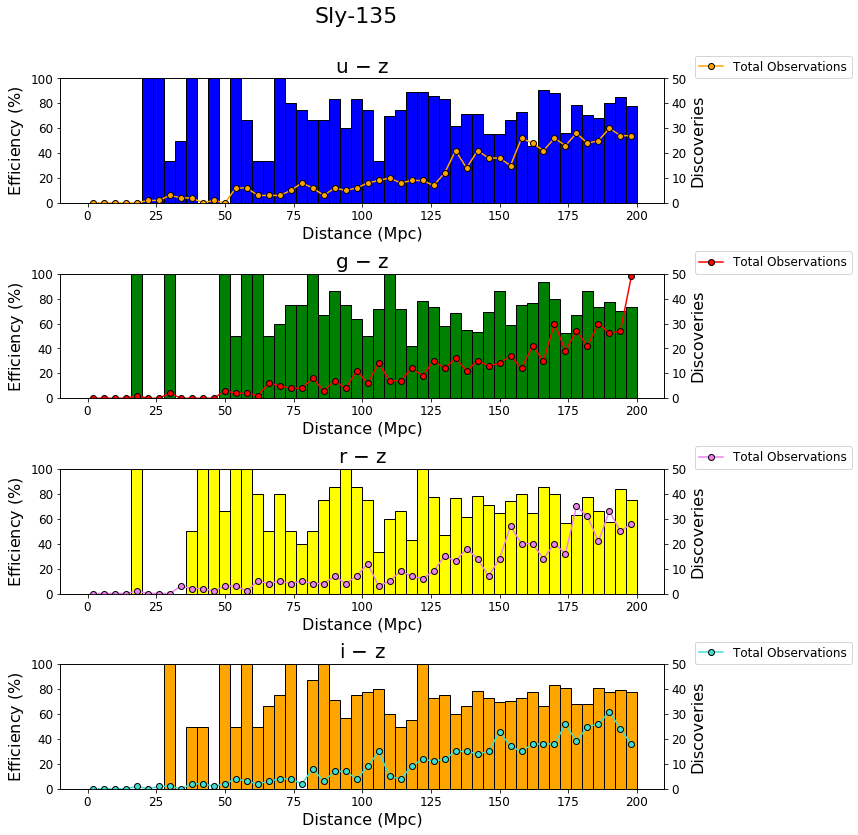

In [328]:
plot_bar2(Sly135_table, 'Sly-135')


### NS-BH Efficiency Plots

In [329]:
plot_bar2(APR4Q3a75_table, 'APR4Q3a75')
plt.close()

In [330]:
plot_bar2(H4Q3a75_table, 'H4Q3a75')
plt.close()

In [331]:
plot_bar2(MS1Q3a75_table, 'MS1Q3a75')
plt.close()

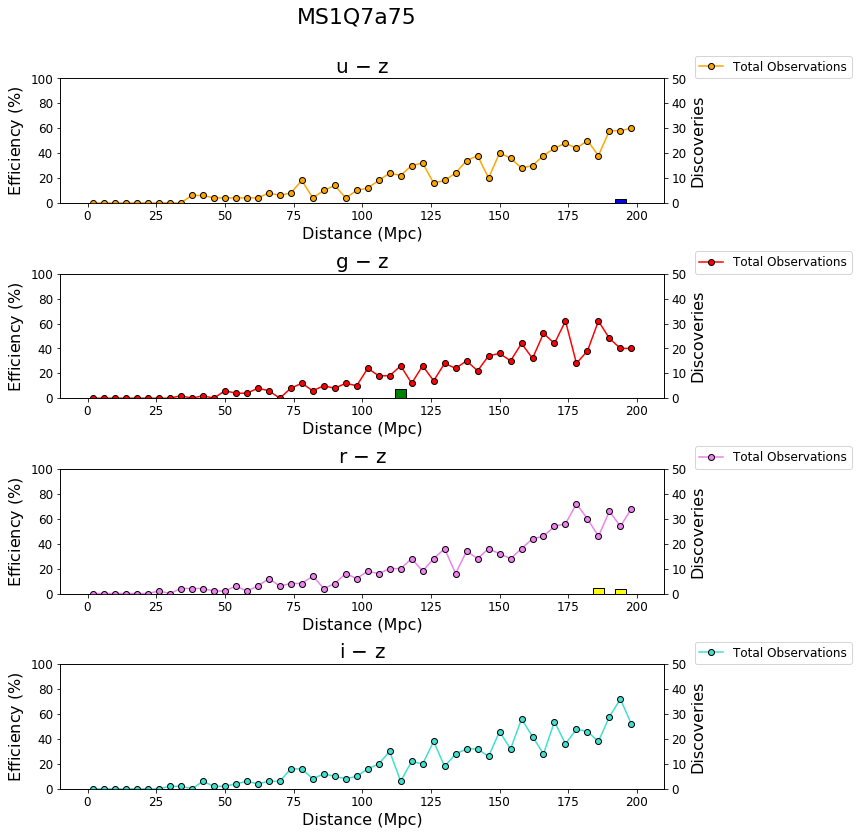

In [332]:
plot_bar2(MS1Q7a75_table, 'MS1Q7a75')
